In [1]:
%env no_proxy='a.test.com,127.0.0.1,2.2.2.2'
!wget https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com:443/20230927/deeplabv3.zip
!unzip -o deeplabv3.zip  # 添加 -o 选项自动确认覆盖

env: no_proxy='a.test.com,127.0.0.1,2.2.2.2'
--2025-09-18 01:23:51--  https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com/20230927/deeplabv3.zip
Resolving proxy-notebook.modelarts.com (proxy-notebook.modelarts.com)... 192.168.0.33
Connecting to proxy-notebook.modelarts.com (proxy-notebook.modelarts.com)|192.168.0.33|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 443385738 (423M) [application/zip]
Saving to: ‘deeplabv3.zip.1’

deeplabv3.zip.1     100%[===================>] 422.84M  40.2MB/s    in 11s     

2025-09-18 01:24:02 (39.6 MB/s) - ‘deeplabv3.zip.1’ saved [443385738/443385738]

Archive:  deeplabv3.zip
  inflating: seg2/.DS_Store          
  inflating: seg2/datachuli.py       
  inflating: seg2/JPEG/.DS_Store     
  inflating: seg2/JPEG/2007_000032.jpg  
  inflating: seg2/JPEG/2007_000033.jpg  
  inflating: seg2/JPEG/2007_000039.jpg  
  inflating: seg2/JPEG/2007_000042.jpg  
  inflating: seg2/JPEG/2007_000061.jpg  
  infl

In [2]:
# os库
import os
# 引入numpy
import numpy as np
# 引入读写不同数据文件格式的函数
import scipy.io
# 引入数据序列化和反序列化
import pickle
# 引入操作图像方法
from PIL import Image
# 引入高级的文件,文件夹,压缩包处理模块
import shutil
# 引入计算机视觉库
import cv2
# 引入归一化提供训练测试所用的数据集
from mindspore.mindrecord import FileWriter
# 引入数据读取
import mindspore.dataset as de
# 引入MindSpore
import mindspore as ms
# 引入神经网络模块
import mindspore.nn as nn
#导入mindspore中的ops模块
import mindspore.ops as P
# 引入张量模块
from mindspore import Tensor
from mindspore import load_checkpoint
from mindspore import load_param_into_net
from mindspore import dtype as mstype
# 引入python解释器和它的环境有关的函数
import sys
# 将字典转为easydict
from easydict import EasyDict as edict
# 引入模型训练或推理的高阶接口。
# 引入用于构建Callback函数基类。
from mindspore.train import ModelCheckpoint, CheckpointConfig,LossMonitor, TimeMonitor,Model
# 引入集合通信接口
from mindspore.communication import init, get_rank, get_group_size
# 引入用于构建Callback函数的基类。
from mindspore import amp
from mindspore import set_seed
import PIL
# 引入绘图模块
import matplotlib.pyplot as plt
# 引入可视化库
import matplotlib as mpl
# 引入可视化库色彩模块
import matplotlib.colors as colors


/usr/local/Ascend/ascend-toolkit/7.0.RC1/python/site-packages/tbe/tvm/contrib/ccec.py:766: DeprecationWarning: invalid escape sequence \L
  if not dirpath.find("AppData\Local\Temp"):
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/classifier/transdata/transdata_classifier.py:222: DeprecationWarning: invalid escape sequence \B
  """
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/unify_schedule/vector/transdata/common/graph/transdata_graph_info.py:140: DeprecationWarning: invalid escape sequence \c
  """
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/unify_schedule/extract_image_patches_without_cbuf_schedule.py:317: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if _ is not 1:


In [3]:
# 设置Opencv的线程数量为0
cv2.setNumThreads(0)
# 数据集对象，用于载入语义分割数据集
class SegDataset:
    def __init__(self,
                 image_mean,# 图像像素值平均值
                 image_std,# 图像像素值标准差
                 data_file='',# 数据集文件路径
                 batch_size=32,# 单次训练所使用样本的数量
                 crop_size=512,# 随机裁剪后的图片大小
                 max_scale=2.0,# 最大缩放比例
                 min_scale=0.5,# 最小缩放比例
                 ignore_label=255,# 忽略标签值
                 num_classes=21,# 图像和标签中的类别数量
                 num_readers=2,# 读取数据的IO线程数量
                 num_parallel_calls=4,# 数据集batch的并行度
                 shard_id=None, # 数据集分片ID，None表示无分片
                 shard_num=None# 数据集分片数量，None表示无分片
                               ):
        # 定义数据集文件路径
        self.data_file = data_file
        # 定义单次训练所使用样本的数量
        self.batch_size = batch_size
        # 定义随机裁剪后的图片大小
        self.crop_size = crop_size
        # 定义图像像素值平均值
        self.image_mean = np.array(image_mean, dtype=np.float32)
        # 定义图像像素值标准差
        self.image_std = np.array(image_std, dtype=np.float32)
        # 定义最大缩放比例
        self.max_scale = max_scale
        # 定义最小缩放比例
        self.min_scale = min_scale
        # 定义忽略标签值
        self.ignore_label = ignore_label
        # 定义图像和标签中的类别数量
        self.num_classes = num_classes
        # 定义读取数据的IO线程数量
        self.num_readers = num_readers
        # 定义数据集batch的并行度
        self.num_parallel_calls = num_parallel_calls
        # 定义数据集分片ID
        self.shard_id = shard_id
        # 定义数据集分片数量
        self.shard_num = shard_num
        # VOC数据集原始图片文件夹路径
        self.voc_img_dir = os.path.join(self.data_file,'JPEG')
        # VOC数据集语义标注图片文件夹路径
        self.voc_anno_dir = os.path.join(self.data_file,'MASK1')
        # VOC数据集训练集文件列表路径
        self.voc_train_lst = os.path.join(self.data_file,'train.txt')
        # VOC数据集验证集文件列表路径
        self.voc_val_lst = os.path.join(self.data_file,'val.txt')
        #  VOC数据集使用的灰度标注图片文件夹路径
        self.voc_anno_gray_dir = os.path.join(self.data_file,'SegmentationClassGray')
        # 生成的MindRecord文件保存路径
        self.mindrecord_save =  os.path.join(self.data_file,'VOC_mindrecord')
        # 最大缩放比例必须大于最小缩放比例                               
        assert max_scale > min_scale
    #数据预处理，包括图像的解码，尺度缩放，随机裁剪等操作
    def preprocess_(self, image, label):
        #bgr图像解码
        image_out = cv2.imdecode(np.frombuffer(image, dtype=np.uint8), cv2.IMREAD_COLOR)
        #灰度图像解码
        label_out = cv2.imdecode(np.frombuffer(label, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        #尺度缩放
        sc = np.random.uniform(self.min_scale, self.max_scale)
        new_h, new_w = int(sc * image_out.shape[0]), int(sc * image_out.shape[1])
        image_out = cv2.resize(image_out, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
        label_out = cv2.resize(label_out, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
        #图像标准化
        image_out = (image_out - self.image_mean) / self.image_std
        #随机裁剪
        h_, w_ = max(new_h, self.crop_size), max(new_w, self.crop_size)
        pad_h, pad_w = h_ - new_h, w_ - new_w
        if pad_h > 0 or pad_w > 0:
            image_out = cv2.copyMakeBorder(image_out, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)
            label_out = cv2.copyMakeBorder(label_out, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=self.ignore_label)
        offset_h = np.random.randint(0, h_ - self.crop_size + 1)
        offset_w = np.random.randint(0, w_ - self.crop_size + 1)
        image_out = image_out[offset_h: offset_h + self.crop_size, offset_w: offset_w + self.crop_size, :]
        label_out = label_out[offset_h: offset_h + self.crop_size, offset_w: offset_w+self.crop_size]
        #随机水平翻转
        if np.random.uniform(0.0, 1.0) > 0.5:
            image_out = image_out[:, ::-1, :]
            label_out = label_out[:, ::-1]
        #图像转置以符合模型输入要求
        image_out = image_out.transpose((2, 0, 1))
        image_out = image_out.copy()
        label_out = label_out.copy()
        return image_out, label_out

    #得到灰度数据集的方法，若文件已存在，则直接返回
    def get_gray_dataset(self):
        if os.path.exists(self.voc_anno_gray_dir):
            print('the gray file is already exists！')
            return
        os.makedirs(self.voc_anno_gray_dir)

        #转换彩色图像为灰度图像，并保存到指定路径
        print('converting voc color png to gray png ...')
        for ann in os.listdir(self.voc_anno_dir):
            ann_im = Image.open(os.path.join(self.voc_anno_dir, ann))
            #将该图像转换为灰度图像
            ann_im = Image.fromarray(np.array(ann_im))
            ann_im.save(os.path.join(self.voc_anno_gray_dir, ann))
        print('converting done')
    #获取MindRecord格式的数据集，num_shards为生成MindRecord的分片数，shuffle为是否对数据做洗牌处理    
    def get_mindrecord_dataset(self, is_training,num_shards=1, shuffle=True):
        datas = []
        if is_training:
            data_lst = self.voc_train_lst
            self.mindrecord_save = os.path.join(self.mindrecord_save,'train')
        else:
            data_lst = self.voc_val_lst
            self.mindrecord_save = os.path.join(self.mindrecord_save,'eval')
        
        if os.path.exists(self.mindrecord_save):
            #shutil.rmtree(self.mindrecord_save)
            print('mindrecord file is already exists！')
            self.mindrecord_save = os.path.join(self.mindrecord_save,'VOC_mindrecord')
            return
        
        with open(data_lst) as f:
            lines = f.readlines()
        if shuffle:
            np.random.shuffle(lines)
            
        print('creating mindrecord dataset...')
        os.makedirs(self.mindrecord_save)
        self.mindrecord_save = os.path.join(self.mindrecord_save,'VOC_mindrecord')
        print('number of samples:', len(lines))
        #定义MindRecord的schema
        seg_schema = {"file_name": {"type": "string"}, "label": {"type": "bytes"}, "data": {"type": "bytes"}}
        writer = FileWriter(file_name=self.mindrecord_save, shard_num=num_shards)
        writer.add_schema(seg_schema, "seg_schema")
        #将schema写入MindRecord
        cnt = 0
        for l in lines:
            id_ = l.strip()
            img_path = os.path.join(self.voc_img_dir, id_ + '.jpg')
            label_path = os.path.join(self.voc_anno_gray_dir, id_ + '.png')
            
            sample_ = {"file_name": img_path.split('/')[-1]}
            with open(img_path, 'rb') as f:
                sample_['data'] = f.read()
            with open(label_path, 'rb') as f:
                sample_['label'] = f.read()
            datas.append(sample_)
            cnt += 1
            if cnt % 1000 == 0:
                writer.write_raw_data(datas)
                print('number of samples written:', cnt)
                datas = []

        if datas:
            writer.write_raw_data(datas)
        writer.commit()
        print('number of samples written:', cnt)
        print('Create Mindrecord Done')
    #生成文件    
    def get_dataset(self, repeat=1):
        data_set = de.MindDataset(dataset_files=self.mindrecord_save, columns_list=["data", "label"],
                                  shuffle=True, num_parallel_workers=self.num_readers,
                                  num_shards=self.shard_num, shard_id=self.shard_id)
        transforms_list = self.preprocess_
        data_set = data_set.map(operations=transforms_list, input_columns=["data", "label"],
                                output_columns=["data", "label"],
                                num_parallel_workers=self.num_parallel_calls)
        data_set = data_set.shuffle(buffer_size=self.batch_size * 10)
        data_set = data_set.batch(self.batch_size, drop_remainder=True)
        data_set = data_set.repeat(repeat)
        return data_set


In [4]:
# 定义1x1卷积层
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, weight_init='xavier_uniform')

# 定义3x3卷积层
def conv3x3(in_planes, out_planes, stride=1, dilation=1, padding=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, pad_mode='pad', padding=padding,
                     dilation=dilation, weight_init='xavier_uniform')

#定义Resnet主体网络
class Resnet(nn.Cell):
    def __init__(self, block, block_num, output_stride, use_batch_statistics=True):
        super(Resnet, self).__init__()
        self.inplanes = 64# 输入通道数
        # 第一层卷积层
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, pad_mode='pad', padding=3,
                               weight_init='xavier_uniform')
        self.bn1 = nn.BatchNorm2d(self.inplanes, use_batch_statistics=use_batch_statistics)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # 第一层残差块
        self.layer1 = self._make_layer(block, 64, block_num[0], use_batch_statistics=use_batch_statistics)
        # 第二层残差块
        self.layer2 = self._make_layer(block, 128, block_num[1], stride=2, use_batch_statistics=use_batch_statistics)
        # 根据输出步长选择第三、第四层残差块
        if output_stride == 16:
            self.layer3 = self._make_layer(block, 256, block_num[2], stride=2,
                                           use_batch_statistics=use_batch_statistics)
            self.layer4 = self._make_layer(block, 512, block_num[3], stride=1, base_dilation=2, grids=[1, 2, 4],
                                           use_batch_statistics=use_batch_statistics)
        elif output_stride == 8:
            self.layer3 = self._make_layer(block, 256, block_num[2], stride=1, base_dilation=2,
                                           use_batch_statistics=use_batch_statistics)
            self.layer4 = self._make_layer(block, 512, block_num[3], stride=1, base_dilation=4, grids=[1, 2, 4],
                                           use_batch_statistics=use_batch_statistics)
    # 构建残差块
    def _make_layer(self, block, planes, blocks, stride=1, base_dilation=1, grids=None, use_batch_statistics=True):
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.SequentialCell([
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion, use_batch_statistics=use_batch_statistics)
            ])

        if grids is None:
            grids = [1] * blocks

        layers = [
            block(self.inplanes, planes, stride, downsample, dilation=base_dilation * grids[0],
                  use_batch_statistics=use_batch_statistics)
        ]
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(
                block(self.inplanes, planes, dilation=base_dilation * grids[i],
                      use_batch_statistics=use_batch_statistics))

        return nn.SequentialCell(layers)
    # 前向推理
    def construct(self, x):
        out = self.conv1(x)# 第一层卷积
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)# 第一层池化
        out = self.layer1(out)  # 第一层残差块
        out = self.layer2(out)  # 第二层残差块
        out = self.layer3(out)  # 第三层残差块
        out = self.layer4(out)  # 第四层残差块

        return out

#构建Bottleneck，用于ResNeXt中构建残差块
class Bottleneck(nn.Cell):
    # 扩充率为4
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, dilation=1, use_batch_statistics=True):
        super(Bottleneck, self).__init__()
        # 第一个1x1卷积层
        self.conv1 = conv1x1(inplanes, planes)
        # 第一个BatchNorm层
        self.bn1 = nn.BatchNorm2d(planes, use_batch_statistics=use_batch_statistics)
        # 第二个3x3卷积层
        self.conv2 = conv3x3(planes, planes, stride, dilation, dilation)
        # 第二个BatchNorm层
        self.bn2 = nn.BatchNorm2d(planes, use_batch_statistics=use_batch_statistics)
        # 第三个1x1卷积层，维度扩充
        self.conv3 = conv1x1(planes, planes * self.expansion)
        # 第三个BatchNorm层
        self.bn3 = nn.BatchNorm2d(planes * self.expansion, use_batch_statistics=use_batch_statistics)
        # Relu激活函数
        self.relu = nn.ReLU()
        # 下采样层，使维度匹配
        self.downsample = downsample
        # 张量相加操作
        self.add = P.Add()

    def construct(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        # 将identity和out相加
        out = self.add(out, identity)
        out = self.relu(out)
        return out

#构建ASPP，用于DeepLabV3+中的ASPP模块
class ASPP(nn.Cell):
    def __init__(self, atrous_rates, phase='train', in_channels=2048, num_classes=21,
                 use_batch_statistics=True):
        super(ASPP, self).__init__()
        # 训练或者测试阶段
        self.phase = phase
        # 输出通道数
        out_channels = 256
        # ASPP卷积层1
        self.aspp1 = ASPPConv(in_channels, out_channels, atrous_rates[0], use_batch_statistics=use_batch_statistics)
         # ASPP卷积层2
        self.aspp2 = ASPPConv(in_channels, out_channels, atrous_rates[1], use_batch_statistics=use_batch_statistics)
         # ASPP卷积层3
        self.aspp3 = ASPPConv(in_channels, out_channels, atrous_rates[2], use_batch_statistics=use_batch_statistics)
         # ASPP卷积层4
        self.aspp4 = ASPPConv(in_channels, out_channels, atrous_rates[3], use_batch_statistics=use_batch_statistics)
        # ASPP池化层
        self.aspp_pooling = ASPPPooling(in_channels, out_channels)
        # 输出通道数为(out_channels * (len(atrous_rates) + 1))
        self.conv1 = nn.Conv2d(out_channels * (len(atrous_rates) + 1), out_channels, kernel_size=1,
                               weight_init='xavier_uniform')
        # BatchNorm层
        self.bn1 = nn.BatchNorm2d(out_channels, use_batch_statistics=use_batch_statistics)
        # Relu激活函数
        self.relu = nn.ReLU()
        # 输出通道数为num_classes
        self.conv2 = nn.Conv2d(out_channels, num_classes, kernel_size=1, weight_init='xavier_uniform', has_bias=True)
        # 沿着通道维度拼接
        self.concat = P.Concat(axis=1)
        # 随机失活，防止过拟合
        self.drop = nn.Dropout(p=0.3)

    def construct(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.aspp_pooling(x)

        x = self.concat((x1, x2))
        x = self.concat((x, x3))
        x = self.concat((x, x4))
        x = self.concat((x, x5))

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # 如果是训练阶段，则进行随机失活
        if self.phase == 'train':
            x = self.drop(x)
        x = self.conv2(x)
        return x

##定义ASPPPooling类，用于定义ASPP池操作
class ASPPPooling(nn.Cell):
    #定义参数
    def __init__(self, in_channels, out_channels, use_batch_statistics=True):
        super(ASPPPooling, self).__init__()
        #定义卷积层操作
        self.conv = nn.SequentialCell([
            #1x1卷积操作
            nn.Conv2d(in_channels, out_channels, kernel_size=1, weight_init='xavier_uniform'),
            #批量归一化操作
            nn.BatchNorm2d(out_channels, use_batch_statistics=use_batch_statistics),
            #激活函数操作
            nn.ReLU()
        ])
        #定义shape操作
        self.shape = P.Shape()

    def construct(self, x):
        #获取输入x的大小
        size = self.shape(x)
        #先对输入x进行全局平均池化操作
        out = nn.AvgPool2d(size[2])(x)
        #再进行卷积、批量归一化、激活操作
        out = self.conv(out)
        #大小变化为输入x的大小
        out = P.ResizeNearestNeighbor((size[2], size[3]), True)(out)
        return out

#定义ASPPConv类，用于定义ASPP卷积操作
class ASPPConv(nn.Cell):
    #定义参数
    def __init__(self, in_channels, out_channels, atrous_rate=1, use_batch_statistics=True):
        super(ASPPConv, self).__init__()
        #根据不同的空洞卷积率定义不同的卷积操作
        if atrous_rate == 1:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, has_bias=False, weight_init='xavier_uniform')
        else:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, pad_mode='pad', padding=atrous_rate,
                             dilation=atrous_rate, weight_init='xavier_uniform')
        #批量归一化操作
        bn = nn.BatchNorm2d(out_channels, use_batch_statistics=use_batch_statistics)
        #激活函数操作
        relu = nn.ReLU()
        #定义卷积层操作
        self.aspp_conv = nn.SequentialCell([conv, bn, relu])

    def construct(self, x):
        #进行卷积、批量归一化、激活操作
        out = self.aspp_conv(x)
        return out

#定义DeepLabV3类，用于定义整个DeepLabV3网络
class DeepLabV3(nn.Cell):
    def __init__(self, phase='train', num_classes=21, output_stride=16, freeze_bn=False):
        super(DeepLabV3, self).__init__()
        #根据输入的参数freeze_bn来判断是否使用批量归一化操作
        use_batch_statistics = not freeze_bn
        #调用Resnet类来构建ResNet网络
        self.resnet = Resnet(Bottleneck, [3, 4, 23, 3], output_stride=output_stride,
                             use_batch_statistics=use_batch_statistics)
        #调用ASPP类来构建ASPP网络
        self.aspp = ASPP([1, 6, 12, 18], phase, 2048, num_classes,
                         use_batch_statistics=use_batch_statistics)
        #定义shape操作
        self.shape = P.Shape()

    def construct(self, x):
        #获取输入x的大小
        size = self.shape(x)
        #将输入x输入到ResNet网络中，得到输出
        out = self.resnet(x)
        #将ResNet的输出输入到ASPP网络中，得到ASPP的输出
        out = self.aspp(out)
        #将ASPP的输出进行大小变换，变成与输入x相同的大小
        out = P.ResizeBilinear((size[2], size[3]), True)(out)
        return out


In [5]:
#定义不同的学习率
#生成cosine学习率下降序列
def cosine_lr(base_lr, decay_steps, total_steps):
    for i in range(int(total_steps)):
        step_ = min(i, decay_steps)
        yield base_lr * 0.5 * (1 + np.cos(np.pi * step_ / decay_steps))

#生成polynomial学习率下降序列
def poly_lr(base_lr, decay_steps, total_steps, end_lr=0.0001, power=0.9):
    for i in range(int(total_steps)):
        step_ = min(i, decay_steps)
        yield (base_lr - end_lr) * ((1.0 - step_ / decay_steps) ** power) + end_lr

#生成exponential学习率下降序列
def exponential_lr(base_lr, decay_steps, decay_rate, total_steps, staircase=False):
    for i in range(total_steps):
        if staircase:
            power_ = i // decay_steps
        else:
            power_ = float(i) / decay_steps
        yield base_lr * (decay_rate ** power_)


In [6]:
#定义损失函数
class SoftmaxCrossEntropyLoss(nn.Cell):
    def __init__(self, num_cls=21, ignore_label=255):
        super(SoftmaxCrossEntropyLoss, self).__init__()
        #one-hot编码相关操作
        self.one_hot = P.OneHot(axis=-1)
        self.on_value = Tensor(1.0, mstype.float32)
        self.off_value = Tensor(0.0, mstype.float32)
        #类型转换相关操作
        self.cast = P.Cast()
        #softmax交叉熵损失函数及相关操作
        self.ce = nn.SoftmaxCrossEntropyWithLogits()
        #类别数及忽略标签
        self.not_equal = P.NotEqual()
        self.num_cls = num_cls
        self.ignore_label = ignore_label
        #矩阵乘法及求和相关操作
        self.mul = P.Mul()
        self.sum = P.ReduceSum(False)
        self.div = P.RealDiv()
        #转置及形状变换相关操作
        self.transpose = P.Transpose()
        self.reshape = P.Reshape()
    #将标签转换为整形
    def construct(self, logits, labels):
        #将标签拉成一维并转换形状
        labels_int = self.cast(labels, mstype.int32)
        labels_int = self.reshape(labels_int, (-1,))
         #将logits转置并转换形状
        logits_ = self.transpose(logits, (0, 2, 3, 1))
        logits_ = self.reshape(logits_, (-1, self.num_cls))
         #生成权重
        weights = self.not_equal(labels_int, self.ignore_label)
        weights = self.cast(weights, mstype.float32)
        #生成one-hot标签
        one_hot_labels = self.one_hot(labels_int, self.num_cls, self.on_value, self.off_value)
        #计算softmax交叉熵损失
        loss = self.ce(logits_, one_hot_labels)
         #加权
        loss = self.mul(weights, loss)
        #求平均损失
        loss = self.div(self.sum(loss), self.sum(weights))
        return loss


In [7]:
# 设置随机种子
set_seed(1)
# 设置上下文
ms.set_context(mode=ms.GRAPH_MODE, save_graphs=False,
                    device_target="Ascend")
# 建立训练网络
class BuildTrainNetwork(nn.Cell):
    def __init__(self, network, criterion):
        super(BuildTrainNetwork, self).__init__()
        self.network = network
        self.criterion = criterion

    def construct(self, input_data, label):
        output = self.network(input_data)
        net_loss = self.criterion(output, label)
        return net_loss
# 训练函数
def train(args):
    # 如果使用分布式训练，则初始化
    if args.is_distributed:
        init()
        args.rank = get_rank()
        args.group_size = get_group_size()

        parallel_mode = ParallelMode.DATA_PARALLEL
        ms.set_auto_parallel_context(parallel_mode=parallel_mode, gradients_mean=True, device_num=args.group_size)
    
    
    # 构建数据集
    dataset = SegDataset(image_mean=args.image_mean,
                                        image_std=args.image_std,
                                        data_file=args.data_file,
                                        batch_size=args.batch_size,
                                        crop_size=args.crop_size,
                                        max_scale=args.max_scale,
                                        min_scale=args.min_scale,
                                        ignore_label=args.ignore_label,
                                        num_classes=args.num_classes,
                                        num_readers=2,
                                        num_parallel_calls=4,
                                        shard_id=args.rank,
                                        shard_num=args.group_size)
    dataset.get_gray_dataset()
    dataset.get_mindrecord_dataset(is_training=True)
    dataset = dataset.get_dataset(repeat=1)
    

    # 构建相关网络
    if args.model == 'deeplab_v3_s16':
        network = DeepLabV3('train', args.num_classes, 16, args.freeze_bn)
    elif args.model == 'deeplab_v3_s8':
        network = DeepLabV3('train', args.num_classes, 8, args.freeze_bn)
    else:
        raise NotImplementedError('model [{:s}] not recognized'.format(args.model))

    # 构建损失函数
    loss_ = SoftmaxCrossEntropyLoss(args.num_classes, args.ignore_label)
    loss_.add_flags_recursive(fp32=True)
    train_net = BuildTrainNetwork(network, loss_)

    # l加载预训练模型
    param_dict = ms.load_checkpoint(args.ckpt_file)
    ms.load_param_into_net(train_net, param_dict)

    # 优化器
    iters_per_epoch = dataset.get_dataset_size()
    total_train_steps = iters_per_epoch * args.train_epochs
    if args.lr_type == 'cos':
        lr_iter = cosine_lr(args.base_lr, total_train_steps, total_train_steps)
    elif args.lr_type == 'poly':
        lr_iter = poly_lr(args.base_lr, total_train_steps, total_train_steps, end_lr=0.0, power=0.9)
    elif args.lr_type == 'exp':
        lr_iter = exponential_lr(args.base_lr, args.lr_decay_step, args.lr_decay_rate,
                                                total_train_steps, staircase=True)
    else:
        raise ValueError('unknown learning rate type')
    opt = nn.Momentum(params=train_net.trainable_params(), learning_rate=lr_iter, momentum=0.9, weight_decay=0.0001,
                      loss_scale=args.loss_scale)

    # 损失梯度缩放
    manager_loss_scale = amp.FixedLossScaleManager(args.loss_scale, drop_overflow_update=False)
    model = Model(train_net, optimizer=opt, amp_level="O3", loss_scale_manager=manager_loss_scale)

    # 回调函数，用于保存 ckpts
    time_cb = TimeMonitor(data_size=iters_per_epoch)
    loss_cb = LossMonitor()
    cbs = [time_cb, loss_cb]

    if args.rank == 0:
        config_ck = CheckpointConfig(save_checkpoint_steps=iters_per_epoch,
                                     keep_checkpoint_max=args.keep_checkpoint_max)
        ckpoint_cb = ModelCheckpoint(prefix=args.model, directory=args.train_dir, config=config_ck)
        cbs.append(ckpoint_cb)
    # 开始训练
    model.train(args.train_epochs, dataset, callbacks=cbs,dataset_sink_mode=True)


In [8]:
##设定相关参数并转为edict对象
cfg = edict({
    "batch_size": 16,
    "crop_size": 513,
    "image_mean": [103.53, 116.28, 123.675],#图片均值
    "image_std": [57.375, 57.120, 58.395],#图片标准差
    "min_scale": 0.5, #最小缩放比例
    "max_scale": 2.0, #最大缩放比例
    "ignore_label": 255, #忽略标签
    "num_classes": 21, #分类数
    "train_epochs" : 1, #训练轮数
    "lr_type": 'cos', #学习率变化方式
    "base_lr": 0.0, #基础学习率
    "lr_decay_step": 3*91, #学习率递减步数
    "lr_decay_rate" :0.1, #学习率递减率
    "loss_scale": 2048, #损失函数缩放比例
    "model": 'deeplab_v3_s8', #模型类型
    'rank': 0, #排名
    'group_size':1, #组大小
    'keep_checkpoint_max':1, #最大保存点数
    'train_dir': 'model', #训练目录
    'is_distributed':False, #是否分布式训练
    'freeze_bn':True #是否冻结BN层
})

#如果训练目录存在，则删除
if os.path.exists(cfg.train_dir):
    shutil.rmtree(cfg.train_dir)
#数据路径和checkpoint路径    
data_path = './seg2'

cfg.data_file = data_path

ckpt_path = './ckpt/deeplab_v3_s8-300_11.ckpt'

cfg.ckpt_file = ckpt_path
#开始训练模型
train(cfg)



the gray file is already exists！
mindrecord file is already exists！


[WARNING] DEVICE(77183,ffff87a100b0,python):2025-09-18-01:24:22.839.038 [mindspore/ccsrc/plugin/device/ascend/hal/device/ascend_runtime_manager.cc:46] GetAscendRuntime] No ascend runtime creator for AscendVM with device id 0
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/unify_schedule/extract_image_patches_without_cbuf_schedule.py:317: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if _ is not 1:
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/unify_schedule/extract_image_patches_without_cbuf_schedule.py:317: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if _ is not 1:
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/unify_schedule/extract_image_patches_without_cbuf_schedule.py:317: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if _ is not 1:
/usr/local/Ascend/ascend-toolkit/latest/python/site-packages/tbe/dsl/unify_schedule/extract_image_patches_without_cbuf_schedule.py:317: Syn

epoch: 1 step: 3, loss is 0.09529081732034683
Train epoch time: 110912.880 ms, per step time: 36970.960 ms


In [9]:
#设置MindSpore的模式为图模式，设备类型为Ascend
ms.set_context(mode=ms.GRAPH_MODE, device_target="Ascend", save_graphs=False)

#计算直方图
def cal_hist(a, b, n):
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(np.int32) + b[k], minlength=n ** 2).reshape(n, n)

#长边缩放函数
def resize_long(img, long_size=513):
    h, w, _ = img.shape
    if h > w:
        new_h = long_size
        new_w = int(1.0 * long_size * w / h)
    else:
        new_w = long_size
        new_h = int(1.0 * long_size * h / w)
    imo = cv2.resize(img, (new_w, new_h))
    return imo

#构建评估网络
class BuildEvalNetwork(nn.Cell):
    def __init__(self, network):
        super(BuildEvalNetwork, self).__init__()
        self.network = network
        self.softmax = nn.Softmax(axis=1)

    def construct(self, input_data):
        output = self.network(input_data)
        output = self.softmax(output)
        return output

#预处理函数
def pre_process(args, img_, crop_size=513):
    # resize
    img_ = resize_long(img_, crop_size)
    resize_h, resize_w, _ = img_.shape

    # mean, std
    image_mean = np.array(args.image_mean)
    image_std = np.array(args.image_std)
    img_ = (img_ - image_mean) / image_std

    # pad to crop_size
    pad_h = crop_size - img_.shape[0]
    pad_w = crop_size - img_.shape[1]
    if pad_h > 0 or pad_w > 0:
        img_ = cv2.copyMakeBorder(img_, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)

    # hwc to chw
    img_ = img_.transpose((2, 0, 1))
    return img_, resize_h, resize_w

# 定义了一个函数eval_batch，用于在输入一张或多张图像时，评估模型的输出值参数args为命令行参数，eval_net为评估用网络，img_lst为输入图像的列表，crop_size为裁剪后的大小，默认为513flip为是否对图像进行镜像翻转，默认为True
def eval_batch(args, eval_net, img_lst, crop_size=513, flip=True):
    # 初始化结果列表
    result_lst = []
    # 获取batch_size
    batch_size = len(img_lst)
    # 初始化batch_img矩阵，尺寸为(batch_size, 3, crop_size, crop_size)
    batch_img = np.zeros((args.batch_size, 3, crop_size, crop_size), dtype=np.float32)
    # 初始化resize_hw列表，用于记录每张图片经过预处理后的尺寸
    resize_hw = []
    # 循环处理每张图片
    for l in range(batch_size):
        # 获取当前图片
        img_ = img_lst[l]
        # 对当前图片进行预处理，返回预处理后的图片，以及裁剪后的高度和宽度
        img_, resize_h, resize_w = pre_process(args, img_, crop_size)
        # 将预处理后的图片加入batch_img矩阵中
        batch_img[l] = img_
        # 将裁剪后的高度和宽度加入resize_hw列表中
        resize_hw.append([resize_h, resize_w])
    # 将batch_img矩阵以连续的方式存储
    batch_img = np.ascontiguousarray(batch_img)
    # 通过评估用网络（eval_net）对batch_img矩阵进行评估，得到输出结果net_out
    net_out = eval_net(Tensor(batch_img, mstype.float32))
    # 将输出结果转换为numpy数组
    net_out = net_out.asnumpy()
    # 如果flip为True，则对batch_img矩阵进行镜像翻转，并再次对翻转后的batch_img矩阵进行评估，将得到的结果加到net_out中  
    if flip:
        batch_img = batch_img[:, :, :, ::-1]
        net_out_flip = eval_net(Tensor(batch_img, mstype.float32))
        net_out += net_out_flip.asnumpy()[:, :, :, ::-1]
    # 循环处理每个batch
    for bs in range(batch_size):
        # 获取输出结果的概率值
        probs_ = net_out[bs][:, :resize_hw[bs][0], :resize_hw[bs][1]].transpose((1, 2, 0))
        # 获取原始图像的高度和宽度
        ori_h, ori_w = img_lst[bs].shape[0], img_lst[bs].shape[1]
        # 将概率值的尺寸调整为原始图像的尺寸
        probs_ = cv2.resize(probs_, (ori_w, ori_h))
        # 将处理后的结果加到结果列表中
        result_lst.append(probs_)
    # 返回结果列表
    return result_lst

#定义了一个函数eval_batch_scales，用于在输入一张或多张图像时，按照不同比例分别进行评估，并将结果加起来参数args为命令行参数，eval_net为评估用网络，img_lst为输入图像的列表，scales为不同比例的列表base_crop_size为基准裁剪尺寸，默认为513，flip为是否对图像进行镜像翻转，默认为True
def eval_batch_scales(args, eval_net, img_lst, scales,
                      base_crop_size=513, flip=True):
    # 根据比例列表计算不同尺寸的裁剪尺寸
    sizes_ = [int((base_crop_size - 1) * sc) + 1 for sc in scales]
    # 对第一个尺寸进行评估，并将结果加入probs_lst列表
    probs_lst = eval_batch(args, eval_net, img_lst, crop_size=sizes_[0], flip=flip)
    # 对其他尺寸进行评估，并将结果加到probs_lst中
    for crop_size_ in sizes_[1:]:
        probs_lst_tmp = eval_batch(args, eval_net, img_lst, crop_size=crop_size_, flip=flip)
        for pl, _ in enumerate(probs_lst):
            probs_lst[pl] += probs_lst_tmp[pl]

    result_msk = []
    for i in probs_lst:
        # 将评估得到的概率值转换为类别号，加入result_msk列表中
        result_msk.append(i.argmax(axis=2))
    # 返回结果列表
    return result_msk

# The color source: print(list(colors.cnames.keys()))
#print(list(colors.cnames.keys()))
num_class = {0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat',
             9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant',
             17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor', 21: 'edge'}

num_color = {0:'aliceblue', 1:'grey', 2:'red', 3:'green', 4:'darkorange', 5:'lime', 6:'bisque',
     7:'black', 8:'blanchedalmond', 9:'blue', 10:'blueviolet', 11:'brown', 12:'burlywood', 13:'cadetblue', 
     14:'darkorange', 15:'tan', 16:'darkviolet', 17:'cornflowerblue', 18:'yellow', 19:'crimson', 20:'darkcyan'}

color_dic = [num_color[k] for k in sorted(num_color.keys())]
bounds = list(range(21))
cmap = mpl.colors.ListedColormap(color_dic)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# 定义一个函数num_to_ClassAndColor，用于将类别号转换为颜色和类别名称
def num_to_ClassAndColor(num_list):
    # 初始化颜色列表和类别列表
    color_ = []
    class_ = []
    # 循环处理每个类别号
    for num in num_list:
        # 将类别号对应的颜色加入颜色列表中
        color_.append(num_class[num])
        # 将类别号对应的类别名称加入类别列表中
        class_.append(num_color[num])
    # 返回颜色列表和类别列表
    return color_,class_


In [10]:
def net_eval(args):
    # 根据命令行参数和模型类型（args.model），创建评估用网络
    if args.model == 'deeplab_v3_s16':
        network = DeepLabV3('eval', args.num_classes, 16, args.freeze_bn)
    elif args.model == 'deeplab_v3_s8':
        network = DeepLabV3('eval', args.num_classes, 8, args.freeze_bn)
    else:
        raise NotImplementedError('model [{:s}] not recognized'.format(args.model))

    eval_net = BuildEvalNetwork(network)

    # 加载训练好的模型参数
    param_dict = load_checkpoint(args.ckpt_file)
    load_param_into_net(eval_net, param_dict)
    # 设置评估用网络为测试状态
    eval_net.set_train(False)
    
   # 读取数据列表
    with open(args.data_lst) as f:
        img_lst = f.readlines()
        
    # evaluate函数,初始化hist矩阵，大小为(args.num_classes, args.num_classes)初始化batch_img_lst和batch_msk_lstbi表示batch中的图片数量，image_num表示总共处理的图片数量

    hist = np.zeros((args.num_classes, args.num_classes))
    batch_img_lst = []
    batch_msk_lst = []
    bi = 0
    image_num = 0
    # 遍历img_lst中的每个id
    for i, line in enumerate(img_lst):
        id_ = line.strip()
        img_path = os.path.join(cfg.voc_img_dir, id_ + '.jpg')
        msk_path = os.path.join(cfg.voc_anno_gray_dir, id_ + '.png')
        # 读取图像和标签    
        img_ = cv2.imread(img_path)
        msk_ = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)
        batch_img_lst.append(img_)
        batch_msk_lst.append(msk_)
        # 判断是否需要输出图片评估结果
        if args.if_png:
            # 对当前batch中的所有图片进行评估
            batch_res = eval_batch_scales(args, eval_net, batch_img_lst, scales=args.scales,
                                          base_crop_size=args.crop_size, flip=args.flip)
             # 获取图像大小
            height ,weight = batch_res[0].shape
            # 将标签中的ignore_label设置为0
            batch_msk_lst[0][batch_msk_lst[0]==args.ignore_label] = 0
            # 绘制三张显示图像、预测结果和标签的子图
            plt.figure(figsize=(3 * weight/1024*10, 2 * height/1024*10))
            plt.subplot(1,3,1)
            image = Image.open(img_path)
            plt.imshow(image)
            
            plt.subplot(1,3,2)
            plt.imshow(image)
            plt.imshow(batch_res[0],alpha=0.8,interpolation='none', cmap=cmap, norm=norm)
            
            
            plt.subplot(1,3,3)
            plt.imshow(image)
            plt.imshow(batch_msk_lst[0],alpha=0.8,interpolation='none', cmap=cmap, norm=norm)
            plt.show()
            # 获取预测结果和真实标签中的唯一值
            prediction_num = np.unique(batch_res[0])
            real_num = np.unique(batch_msk_lst[0])
            # 获取预测结果和真实标签对应的颜色值和类别名
            prediction_color,prediction_class = num_to_ClassAndColor(prediction_num)
            print('prediction num:',prediction_num)
            print('prediction color:',prediction_color)
            print('prediction class:',prediction_class)
            real_color,real_class = num_to_ClassAndColor(real_num)
            print('groundtruth num:',real_num)
            print('groundtruth color:',real_color)
            print('groundtruth class:',real_class)
            # 清空batch_img_lst和batch_msk_lst，用于存储下一个batch的图像和标签
            batch_img_lst = []
            batch_msk_lst = []
            # 判断当前处理的图片数是否小于args.num_png
            if i < args.num_png-1:
                continue
            else:
                return
        # 如果当前batch已经存满，则对这些图片进行评估    
        bi += 1
        if bi == args.batch_size:
            batch_res = eval_batch_scales(args, eval_net, batch_img_lst, scales=args.scales,
                                          base_crop_size=args.crop_size, flip=args.flip)
            # 计算当前batch的混淆矩阵，并将其累加到hist中
            for mi in range(args.batch_size):
                hist += cal_hist(batch_msk_lst[mi].flatten(), batch_res[mi].flatten(), args.num_classes)

            bi = 0
            batch_img_lst = []
            batch_msk_lst = []
            # 每处理100张图像，输出处理进度
            if (i+1)%100 == 0:
                print('processed {} images'.format(i+1))
        image_num = i
    # 如果batch中还有剩余的图片，则对其进行评估
    if bi > 0:
        batch_res = eval_batch_scales(args, eval_net, batch_img_lst, scales=args.scales,
                                      base_crop_size=args.crop_size, flip=args.flip)
        # 计算当前batch的混淆矩阵，并将其累加到hist中
        for mi in range(bi):
            hist += cal_hist(batch_msk_lst[mi].flatten(), batch_res[mi].flatten(), args.num_classes)
        if (i+1) % 100 == 0:
            print('processed {} images'.format(image_num + 1))
    # 计算每个类别的IoU，求其平均值作为结果输出
    np.seterr(divide="ignore", invalid="ignore")
    iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
    print('mean IoU', np.nanmean(iu))


In [11]:
# test  1
# 定义配置文件
cfg = edict({
    "batch_size": 1, # 批大小
    "crop_size": 513, # 图像裁剪大小
    "image_mean": [103.53, 116.28, 123.675], # RGB图像为3通道，定义图像RGB均值
    "image_std": [57.375, 57.120, 58.395], # RGB图像为3通道，定义图像RGB标准差
    "scales": [1.0], # 数据增强的尺度范围
    # [0.5,0.75,1.0,1.25,1.75]
    'flip': True, # 是否进行翻转
    'ignore_label': 255, # 忽略标签的像素值
    'num_classes':21, # 类别数，此处为PASCAL VOC数据集
    'model': 'deeplab_v3_s8', # 模型名称
    'freeze_bn': True, # BN冻结，是否使用BN层

    'if_png':False,        # 数据是否使用png格式
    'num_png':10           # 数据集中的png图像数量
})

# 数据集路径
data_path = './seg2'
# if not os.path.exists(data_path):
     #mox.file.copy_parallel(src_url="s3://share-course/dataset/voc2012_raw/", dst_url=data_path)
cfg.data_file = data_path

# 定义数据集
dataset = SegDataset(image_mean=cfg.image_mean,
                                    image_std=cfg.image_std,
                                    data_file=cfg.data_file)
# 获取灰度图像数据集
dataset.get_gray_dataset()
# 数据集的txt标签路径
cfg.data_lst = os.path.join(cfg.data_file,'val.txt')
# VOC数据集中的图像路径
cfg.voc_img_dir = os.path.join(cfg.data_file,'JPEG')
# VOC数据集中的标签图像路径
cfg.voc_anno_gray_dir = os.path.join(cfg.data_file,'SegmentationClassGray')

ckpt_path = './ckpt'
# if not os.path.exists(ckpt_path):
#     mox.file.copy_parallel(src_url="s3://yyq-3/DATA/code/deeplabv3/model", dst_url=ckpt_path)   #if yours model had saved
# 加载模型文件路径
cfg.ckpt_file = os.path.join(ckpt_path,'deeplab_v3_s8-300_11.ckpt')  
print('loading checkpoing:',cfg.ckpt_file)
# 模型验证评估
net_eval(cfg)


the gray file is already exists！
loading checkpoing: ./ckpt/deeplab_v3_s8-300_11.ckpt


[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:26:44.658.512 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/698760390.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:26:44.658.584 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/698760390.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:26:44.663.299 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:26:44.663.531 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:26:44.664.251 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:26:44.664.658 [mindspore/core/u

mean IoU 0.8696117343344455


the gray file is already exists！
loading checkpoing: ./ckpt/deeplab_v3_s8-300_11.ckpt


[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:27:06.761.402 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/698760390.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:27:06.761.474 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/698760390.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:27:06.765.710 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:27:06.765.961 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:27:06.766.701 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:27:06.767.106 [mindspore/core/u

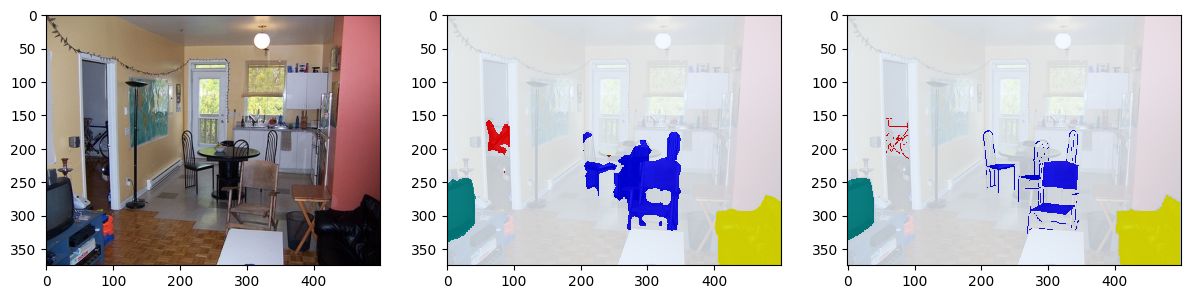

prediction num: [ 0  2  9 11 18 20]
prediction color: ['background', 'bicycle', 'chair', 'diningtable', 'sofa', 'tvmonitor']
prediction class: ['aliceblue', 'red', 'blue', 'brown', 'yellow', 'darkcyan']
groundtruth num: [ 0  2  9 18 20]
groundtruth color: ['background', 'bicycle', 'chair', 'sofa', 'tvmonitor']
groundtruth class: ['aliceblue', 'red', 'blue', 'yellow', 'darkcyan']


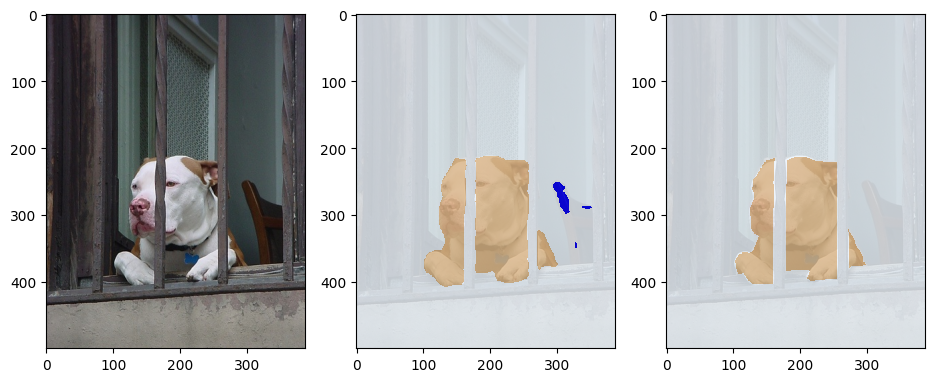

prediction num: [ 0  9 12]
prediction color: ['background', 'chair', 'dog']
prediction class: ['aliceblue', 'blue', 'burlywood']
groundtruth num: [ 0 12]
groundtruth color: ['background', 'dog']
groundtruth class: ['aliceblue', 'burlywood']


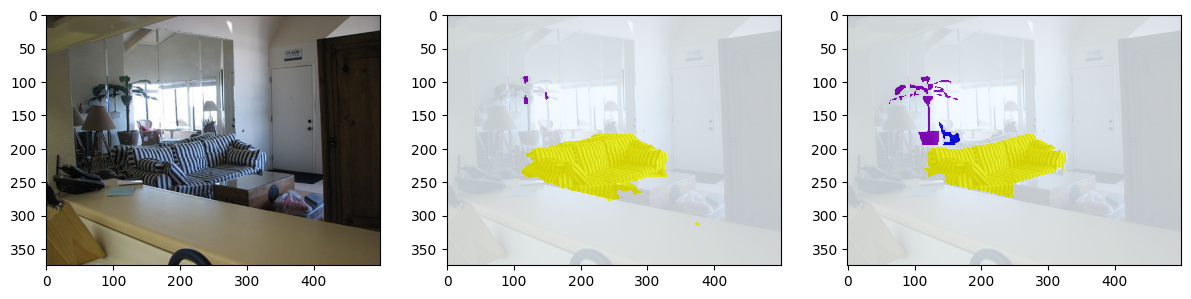

prediction num: [ 0 16 18]
prediction color: ['background', 'pottedplant', 'sofa']
prediction class: ['aliceblue', 'darkviolet', 'yellow']
groundtruth num: [ 0  9 16 18]
groundtruth color: ['background', 'chair', 'pottedplant', 'sofa']
groundtruth class: ['aliceblue', 'blue', 'darkviolet', 'yellow']


In [12]:
# test 2
cfg = edict({
    "batch_size": 1, # 批大小
    "crop_size": 513, # 图像裁剪大小
    "image_mean": [103.53, 116.28, 123.675], # RGB图像为3通道，定义图像RGB均值
    "image_std": [57.375, 57.120, 58.395], # RGB图像为3通道，定义图像RGB标准差
    "scales": [1.0], # 数据增强的尺度范围
    # [0.5,0.75,1.0,1.25,1.75]
    'flip': True, # 是否进行翻转
    'ignore_label': 255, # 忽略标签的像素值
    'num_classes':21, # 类别数，此处为PASCAL VOC数据集
    'model': 'deeplab_v3_s8', # 模型名称
    'freeze_bn': True, # BN冻结，是否使用BN层

    'if_png':True,         # 图像数据是否使用png格式
    'num_png':3            # png图像数量
})



# import moxing as mox
data_path = './seg2'
# if not os.path.exists(data_path):
#     mox.file.copy_parallel(src_url="s3://share-course/dataset/voc2012_raw/", dst_url=data_path)
# 数据集路径
cfg.data_file = data_path

# 定义数据集
dataset = SegDataset(image_mean=cfg.image_mean,
                                    image_std=cfg.image_std,
                                    data_file=cfg.data_file)
dataset.get_gray_dataset()
# 数据集的txt标签路径
cfg.data_lst = os.path.join(cfg.data_file,'val.txt')
# VOC数据集中的图像路径
cfg.voc_img_dir = os.path.join(cfg.data_file,'JPEG')
# VOC数据集中的标签图像路径
cfg.voc_anno_gray_dir = os.path.join(cfg.data_file,'SegmentationClassGray')

ckpt_path = './ckpt'
# if not os.path.exists(ckpt_path):
#     mox.file.copy_parallel(src_url="s3://yyq-3/DATA/code/deeplabv3/model", dst_url=ckpt_path)     #if yours model had saved
cfg.ckpt_file = os.path.join(ckpt_path,'deeplab_v3_s8-300_11.ckpt') \
# 加载模型文件路径 
print('loading checkpoing:',cfg.ckpt_file)
# 模型验证评估
net_eval(cfg)


the gray file is already exists！
Multi-scale inference test (scales=[0.75, 1.0, 1.25]), loading model: ./ckpt/deeplab_v3_s8-300_11.ckpt


[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:05.522.052 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/698760390.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:05.522.127 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/698760390.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:05.527.217 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:05.527.455 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:05.528.158 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:05.528.577 [mindspore/core/u

[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:21.506.397 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/698760390.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:21.506.466 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/698760390.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:21.510.730 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:21.510.976 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:21.511.728 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:21.512.123 [mindspore/core/u

[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:37.323.373 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/698760390.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:37.323.445 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/698760390.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:37.327.595 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:37.327.821 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:37.328.585 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-01:56:37.329.004 [mindspore/core/u

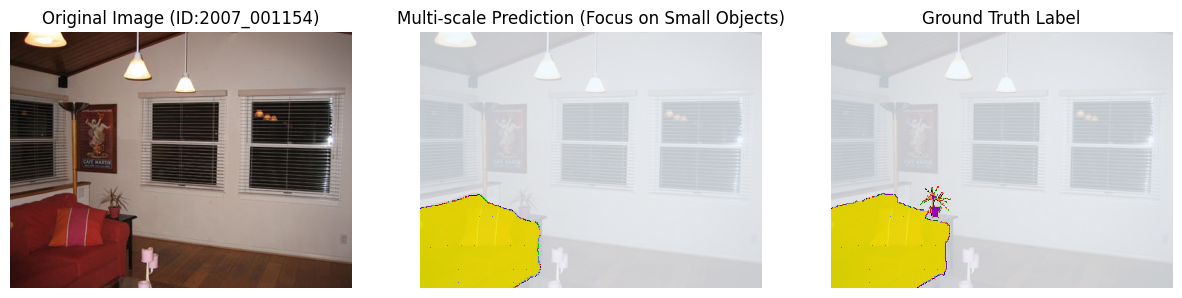

No small objects detected in image 2007_001154


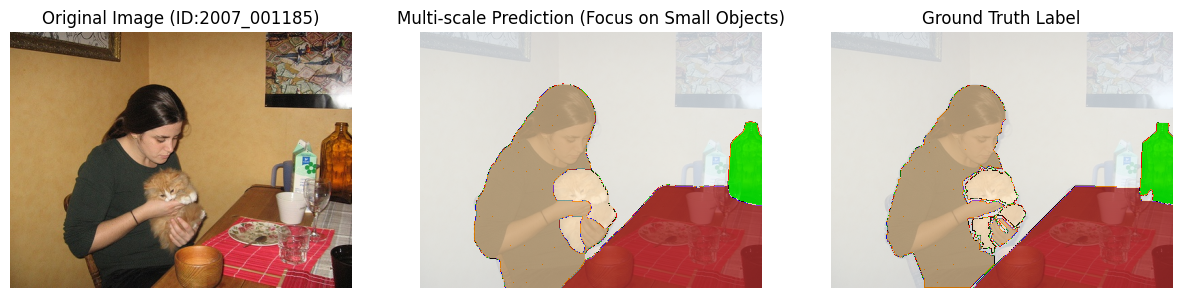

Small objects detected in image 2007_001185: ['bottle']


In [19]:
# test 3: Multi-scale Fusion Inference Test
cfg = edict({
    "batch_size": 1,
    "crop_size": 513,
    "image_mean": [103.53, 116.28, 123.675],
    "image_std": [57.375, 57.120, 58.395],
    "scales": [0.75, 1.0, 1.25],  # Multi-scale fusion (downscale + original + upscale)
    "flip": True,  # Combine horizontal flip to enhance robustness
    "ignore_label": 255,
    "num_classes": 21,
    "model": "deeplab_v3_s8",  # Keep original model
    "freeze_bn": True,
    "if_png": True,  # Display result images
    "num_png": 2,    # Test 2 images containing small objects
    "data_lst": os.path.join("./seg2", "val.txt")  # Select images from validation set
})

# Dataset and model path configuration
cfg.data_file = "./seg2"
dataset = SegDataset(image_mean=cfg.image_mean, image_std=cfg.image_std, data_file=cfg.data_file)
dataset.get_gray_dataset()  # Reuse grayscale labels (generated in original code)
cfg.voc_img_dir = os.path.join(cfg.data_file, "JPEG")
cfg.voc_anno_gray_dir = os.path.join(cfg.data_file, "SegmentationClassGray")
cfg.ckpt_file = os.path.join("./ckpt", "deeplab_v3_s8-300_11.ckpt")

print(f"Multi-scale inference test (scales={cfg.scales}), loading model: {cfg.ckpt_file}")

# Dedicated evaluation function for multi-scale inference (enhance small object display and analysis)
def net_eval_multi_scale(args):
    # 1. Initialize model (reuse original DeepLabV3 structure)
    if args.model == "deeplab_v3_s8":
        network = DeepLabV3("eval", args.num_classes, 8, args.freeze_bn)
    else:
        raise NotImplementedError(f"Model {args.model} is not defined")
    eval_net = BuildEvalNetwork(network)
    param_dict = load_checkpoint(args.ckpt_file)
    load_param_into_net(eval_net, param_dict)
    eval_net.set_train(False)

    # 2. Fix the two images to test: 2007_001154 and 2007_001185
    img_lst = ["2007_001154", "2007_001185"]  # Directly specify image IDs for testing

    # 3. Inference and result display
    for i, id_ in enumerate(img_lst[:args.num_png]):
        img_path = os.path.join(args.voc_img_dir, f"{id_}.jpg")
        msk_path = os.path.join(args.voc_anno_gray_dir, f"{id_}.png")
        img_ = cv2.imread(img_path)
        msk_ = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)
        msk_[msk_ == args.ignore_label] = 0  # Filter ignore label

        # Multi-scale fusion inference
        batch_res = eval_batch_scales(args, eval_net, [img_], scales=args.scales, base_crop_size=args.crop_size)
        pred_msk = batch_res[0]

        # 4. Plotting (highlight small object areas)
        plt.figure(figsize=(15, 5))
        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img_, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Image (ID:{id_})", fontsize=12)
        plt.axis("off")
        # Multi-scale prediction result
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(img_, cv2.COLOR_BGR2RGB))
        plt.imshow(pred_msk, alpha=0.8, cmap=cmap, norm=norm)
        plt.title(f"Multi-scale Prediction (Focus on Small Objects)", fontsize=12)
        plt.axis("off")
        # Ground truth label
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(img_, cv2.COLOR_BGR2RGB))
        plt.imshow(msk_, alpha=0.8, cmap=cmap, norm=norm)
        plt.title(f"Ground Truth Label", fontsize=12)
        plt.axis("off")
        plt.show()

        # Analyze small object detection results
        pred_classes = np.unique(pred_msk)
        small_objs = [cls for cls in pred_classes if cls in [5, 16]]  # 5:bottle, 16:pottedplant
        if small_objs:
            print(f"Small objects detected in image {id_}: {[num_class[cls] for cls in small_objs]}")
        else:
            print(f"No small objects detected in image {id_}")

# Execute multi-scale test
net_eval_multi_scale(cfg)

[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:12:24.836.367 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/698760390.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:12:24.836.439 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/698760390.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:12:24.841.505 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:12:24.841.736 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:12:24.842.431 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:12:24.842.829 [mindspore/core/u

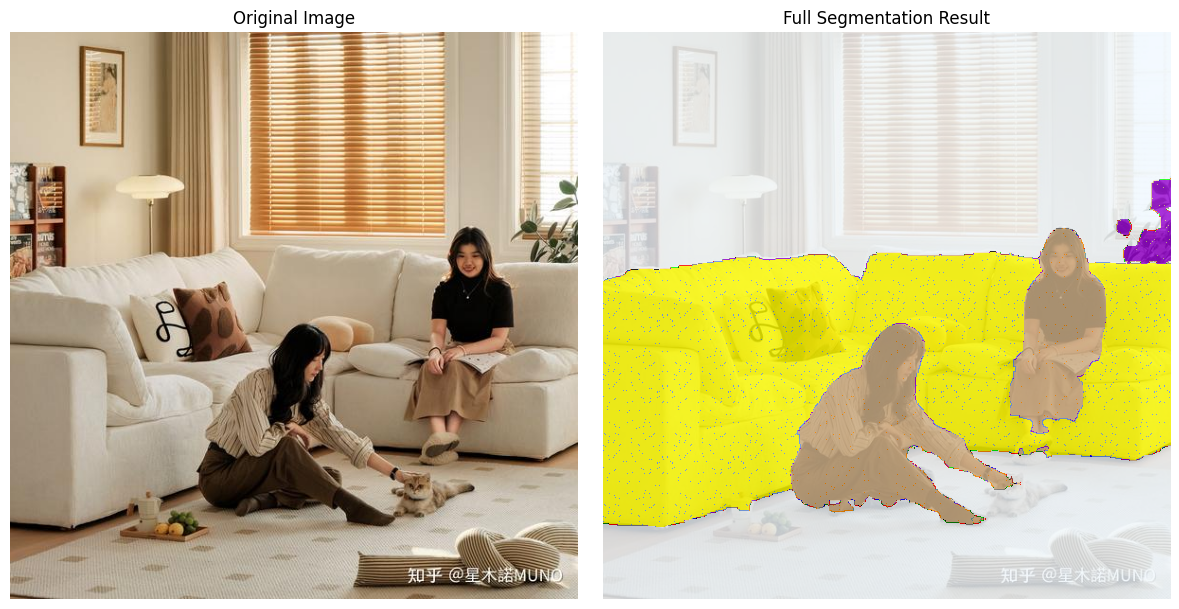

Generating individual images for each detected class...


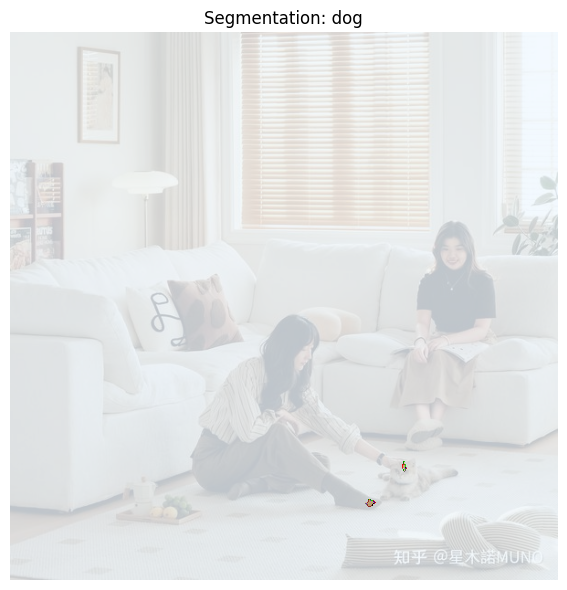

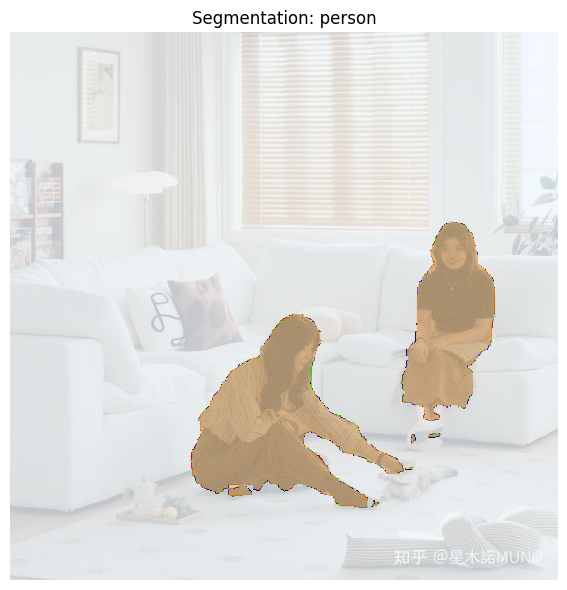

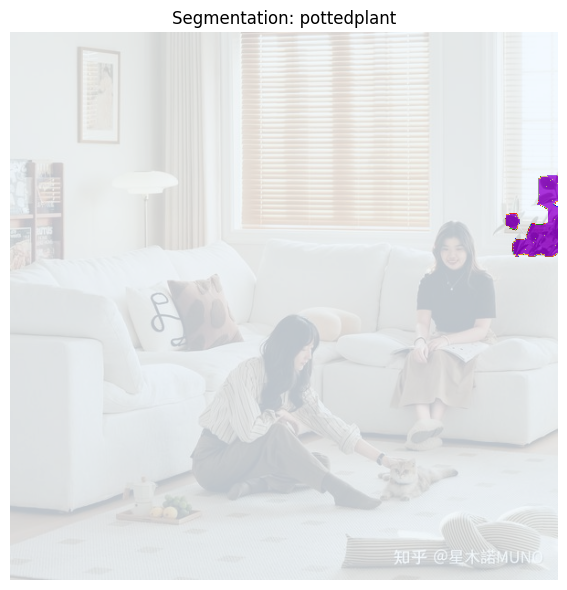

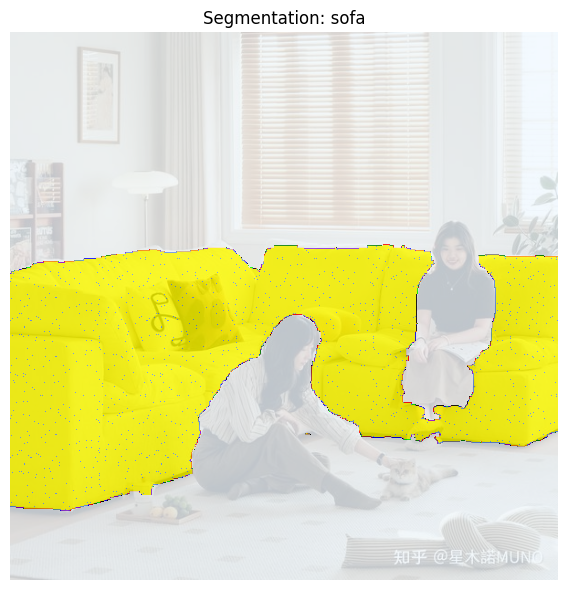

Custom image prediction results:
- Detected object categories: ['dog', 'person', 'pottedplant', 'sofa']
- Number of valid categories: 4 (total 20 detectable categories)


In [22]:
# test 4: 自定义单张图片测试（支持用户上传图）
cfg = edict({
    "batch_size": 1,
    "crop_size": 513,
    "image_mean": [103.53, 116.28, 123.675],
    "image_std": [57.375, 57.120, 58.395],
    "scales": [1.0],  # Single-scale fast inference
    "flip": False,    # Disable flipping to reduce inference time
    "ignore_label": 255,
    "num_classes": 21,
    "model": "deeplab_v3_s8",
    "freeze_bn": True,
    "custom_img_path": "./seg2/custom_test.jpg"  # Unified path
})

# Custom image inference function with individual class visualization
def test_custom_image(args):
    # 1. Check and create seg2 directory (if it doesn't exist)
    seg_dir = os.path.dirname(args.custom_img_path)
    if not os.path.exists(seg_dir):
        try:
            os.makedirs(seg_dir)
            print(f"Created image storage directory: {seg_dir}")
            print(f"Please name your test image 'custom_test.jpg' and upload it to this directory")
            return
        except Exception as e:
            raise IOError(f"Failed to create directory {seg_dir}: {str(e)}")
    
    # 2. Load pre-trained model
    network = DeepLabV3("eval", args.num_classes, 8, args.freeze_bn)
    eval_net = BuildEvalNetwork(network)
    param_dict = load_checkpoint(os.path.join("./ckpt", "deeplab_v3_s8-300_11.ckpt"))
    load_param_into_net(eval_net, param_dict)
    eval_net.set_train(False)
    
    # 3. Verify custom image path
    if not os.path.exists(args.custom_img_path):
        raise FileNotFoundError(
            f"Custom image not found: {args.custom_img_path}\n"
            f"Please upload the image to {seg_dir} directory and name it custom_test.jpg"
        )
    
    img_ = cv2.imread(args.custom_img_path)
    if img_ is None:
        raise ValueError("Failed to read image, possibly due to incorrect format or corrupted file\nOnly jpg/png formats are supported")
    
    # 4. Image preprocessing
    img_prep, resize_h, resize_w = pre_process(args, img_, args.crop_size)
    batch_img = np.expand_dims(img_prep, axis=0)
    
    # 5. Model inference
    net_out = eval_net(Tensor(batch_img, mstype.float32))
    net_out = net_out.asnumpy()[0]
    pred_msk = net_out[:, :resize_h, :resize_w].transpose((1, 2, 0)).argmax(axis=2)
    pred_msk = cv2.resize(pred_msk, (img_.shape[1], img_.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # 6. Get detected classes (excluding background)
    pred_classes = np.unique(pred_msk)
    detected_classes = [cls for cls in pred_classes if cls != 0]
    pred_class_names = [num_class[cls] for cls in detected_classes]
    
    # 7. Display original image and full segmentation result
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_, cv2.COLOR_BGR2RGB))
    plt.title("Original Image", fontsize=12)
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_, cv2.COLOR_BGR2RGB))
    plt.imshow(pred_msk, alpha=0.8, cmap=cmap, norm=norm)
    plt.title("Full Segmentation Result", fontsize=12)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    # 8. Generate separate image for each detected class
    print(f"Generating individual images for each detected class...")
    for cls in detected_classes:
        class_name = num_class[cls]
        
        # Create mask for current class only
        class_mask = np.zeros_like(pred_msk)
        class_mask[pred_msk == cls] = cls  # Keep only current class
        
        # Create and display the individual class image
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(img_, cv2.COLOR_BGR2RGB))
        plt.imshow(class_mask, alpha=0.8, cmap=cmap, norm=norm)
        plt.title(f"Segmentation: {class_name}", fontsize=12)
        plt.axis("off")
        plt.tight_layout()
        plt.show()
    
    # 9. Output prediction statistics
    print(f"Custom image prediction results:")
    print(f"- Detected object categories: {pred_class_names}")
    print(f"- Number of valid categories: {len(pred_class_names)} (total 20 detectable categories)")

# Execute custom image test
test_custom_image(cfg)

In [23]:
# test 5: 批量10图验证（统计整体性能）
cfg = edict({
    "batch_size": 2,  # 批量大小=2（加速推理）
    "crop_size": 513,
    "image_mean": [103.53, 116.28, 123.675],
    "image_std": [57.375, 57.120, 58.395],
    "scales": [1.0],
    "flip": True,
    "ignore_label": 255,
    "num_classes": 21,
    "model": "deeplab_v3_s8",
    "freeze_bn": True,
    "data_lst": os.path.join("./seg2", "val.txt"),  # 验证集列表路径
    "test_num": 10  # 批量测试10张图片
})

# 批量验证函数（输出整体性能统计）
def batch_evaluation(args):
    # 1. 初始化模型
    network = DeepLabV3("eval", args.num_classes, 8, args.freeze_bn)
    eval_net = BuildEvalNetwork(network)
    param_dict = load_checkpoint(os.path.join("./ckpt", "deeplab_v3_s8-300_11.ckpt"))
    load_param_into_net(eval_net, param_dict)
    eval_net.set_train(False)

    # 2. 读取验证集样本（取前10张）
    with open(args.data_lst) as f:
        img_ids = [line.strip() for line in f.readlines()][:args.test_num]
    print(f"批量验证启动：共测试{len(img_ids)}张图片（验证集前10张）")

    # 3. 初始化统计工具
    hist = np.zeros((args.num_classes, args.num_classes))  # 混淆矩阵（计算IoU）
    class_detected = {cls: 0 for cls in range(1, args.num_classes)}  # 统计每类检测次数（排除背景）

    # 4. 批量推理与统计
    batch_img = []  # 批量存储图像
    batch_gt = []   # 批量存储真实标签
    for idx, img_id in enumerate(img_ids):
        # 读取图像与标签
        img_path = os.path.join("./seg2/JPEG", f"{img_id}.jpg")
        gt_path = os.path.join("./seg2/SegmentationClassGray", f"{img_id}.png")
        batch_img.append(cv2.imread(img_path))
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        gt[gt == args.ignore_label] = 0  # 过滤忽略标签
        batch_gt.append(gt)

        # 满batch或最后一批时执行推理
        if len(batch_img) == args.batch_size or idx == len(img_ids) - 1:
            # 批量推理
            pred_batch = eval_batch_scales(args, eval_net, batch_img, scales=args.scales)
            # 更新混淆矩阵与类别统计
            for pred, gt in zip(pred_batch, batch_gt):
                # 累积混淆矩阵
                hist += cal_hist(gt.flatten(), pred.flatten(), args.num_classes)
                # 统计当前batch的类别检测次数
                pred_cls = np.unique(pred)
                for cls in pred_cls:
                    if cls != 0:  # 排除背景类
                        class_detected[cls] += 1
            # 清空batch缓存
            batch_img = []
            batch_gt = []
        
        # 打印进度
        if (idx + 1) % 2 == 0:
            print(f"已完成 {idx + 1}/{len(img_ids)} 张图片推理")

    # 5. 计算性能指标
    # 平均IoU（排除背景类）
    iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
    mean_iou = np.nanmean(iu[1:])  # 跳过背景类（0类）
    # 每类检测覆盖率（检测次数/总测试数）
    class_coverage = {
        num_class[cls]: f"{cnt/args.test_num:.1%}" 
        for cls, cnt in class_detected.items() if cnt > 0
    }

    # 6. 输出统计报告
    print("\n" + "="*50)
    print(f"批量10图验证性能报告")
    print(f"="*50)
    print(f"1. 整体性能：")
    print(f"   - 平均IoU（排除背景）：{mean_iou:.3f}")
    print(f"   - 检测到有效类别数：{len(class_coverage)} / 20（共20个可检测类别）")
    print(f"2. 各类别检测覆盖率（检测次数/10次测试）：")
    for cls_name, coverage in sorted(class_coverage.items()):
        print(f"   - {cls_name:15s}：{coverage}")
    print(f"3. 性能分析：")
    if mean_iou >= 0.6:
        print(f"   - 模型性能优秀：平均IoU≥0.6，可满足大部分场景需求")
    elif 0.4 <= mean_iou < 0.6:
        print(f"   - 模型性能中等：建议增加训练数据或调整学习率策略")
    else:
        print(f"   - 模型性能较差：需检查数据预处理、模型权重或训练参数")
    print("="*50)

# 执行批量验证
batch_evaluation(cfg)

批量验证启动：共测试10张图片（验证集前10张）


[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:17:13.113.603 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/698760390.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:17:13.113.679 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/698760390.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:17:13.118.621 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:17:13.118.852 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:17:13.119.558 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:17:13.119.958 [mindspore/core/u

已完成 2/10 张图片推理
已完成 4/10 张图片推理
已完成 6/10 张图片推理
已完成 8/10 张图片推理
已完成 10/10 张图片推理

批量10图验证性能报告
1. 整体性能：
   - 平均IoU（排除背景）：0.711
   - 检测到有效类别数：14 / 20（共20个可检测类别）
2. 各类别检测覆盖率（检测次数/10次测试）：
   - aeroplane      ：20.0%
   - bicycle        ：10.0%
   - boat           ：20.0%
   - bottle         ：20.0%
   - bus            ：10.0%
   - car            ：10.0%
   - cat            ：10.0%
   - chair          ：30.0%
   - diningtable    ：30.0%
   - dog            ：20.0%
   - person         ：30.0%
   - pottedplant    ：10.0%
   - sofa           ：20.0%
   - tvmonitor      ：10.0%
3. 性能分析：
   - 模型性能优秀：平均IoU≥0.6，可满足大部分场景需求


In [28]:
# test 6: 详细IoU分析（定位弱类别）
cfg = edict({
    "batch_size": 1,
    "crop_size": 513,
    "image_mean": [103.53, 116.28, 123.675],
    "image_std": [57.375, 57.120, 58.395],
    "scales": [1.0],
    "flip": True,
    "ignore_label": 255,
    "num_classes": 21,
    "model": "deeplab_v3_s8",
    "freeze_bn": True,
    "data_lst": os.path.join("./seg2", "val.txt")  # 验证集路径（取30张足够统计）
})

# 详细IoU分析函数
def detailed_iou_analysis(args):
    # 1. 初始化模型与混淆矩阵
    network = DeepLabV3("eval", args.num_classes, 8, args.freeze_bn)
    eval_net = BuildEvalNetwork(network)
    param_dict = load_checkpoint(os.path.join("./ckpt", "deeplab_v3_s8-300_11.ckpt"))
    load_param_into_net(eval_net, param_dict)
    eval_net.set_train(False)

    hist = np.zeros((args.num_classes, args.num_classes))  # 混淆矩阵
    # 读取验证集（取30张样本，统计更可靠）
    with open(args.data_lst) as f:
        img_ids = [line.strip() for line in f.readlines()][:30]
    print(f"详细IoU分析启动：共测试{len(img_ids)}张验证集图片，计算每类IoU...")

    # 2. 推理并累积混淆矩阵
    for img_id in img_ids:
        img_path = os.path.join("./seg2/JPEG", f"{img_id}.jpg")
        gt_path = os.path.join("./seg2/SegmentationClassGray", f"{img_id}.png")
        img_ = cv2.imread(img_path)
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        gt[gt == args.ignore_label] = 0  # 过滤忽略标签

        # 单图推理
        pred = eval_batch_scales(args, eval_net, [img_], scales=args.scales)[0]
        # 累积混淆矩阵
        hist += cal_hist(gt.flatten(), pred.flatten(), args.num_classes)

    # 3. 计算每类IoU（处理NaN值：无样本的类别IoU设为0）
    iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
    iu = np.nan_to_num(iu, nan=0.0)  # 将NaN替换为0（无该类样本时）

    # 4. 类别分级（按IoU值划分强/中/弱类别）
    strong_cls = []  # 强类别：IoU≥0.5（性能优秀）
    medium_cls = []  # 中等类别：0.3≤IoU<0.5（性能一般）
    weak_cls = []     # 弱类别：IoU<0.3（需优化）
    for cls_idx in range(1, args.num_classes):  # 跳过背景类（0类）
        cls_name = num_class[cls_idx]
        cls_iou = iu[cls_idx]
        if cls_iou >= 0.5:
            strong_cls.append((cls_name, cls_iou))
        elif 0.3 <= cls_iou < 0.5:
            medium_cls.append((cls_name, cls_iou))
        else:
            weak_cls.append((cls_name, cls_iou))

    # 5. 输出详细分析报告
    print("\n" + "="*60)
    print("详细IoU分析报告（基于30张验证集图片）")
    print("="*60)
    print(f"基础指标：")
    print(f"   - 平均IoU（排除背景）：{np.mean(iu[1:]):.3f}")
    print(f"   - 强类别数：{len(strong_cls)} / 20")
    print(f"   - 中等类别数：{len(medium_cls)} / 20")
    print(f"   - 弱类别数：{len(weak_cls)} / 20")
    print("\n1. 强类别（IoU≥0.5）：")
    for name, iou in sorted(strong_cls, key=lambda x: x[1], reverse=True):
        print(f"   - {name:15s}：IoU={iou:.3f}")
    print("\n2. 中等类别（0.3≤IoU<0.5）：")
    for name, iou in sorted(medium_cls, key=lambda x: x[1], reverse=True):
        print(f"   - {name:15s}：IoU={iou:.3f}")
    print("\n3. 弱类别（IoU<0.3）：")
    if weak_cls:
        for name, iou in sorted(weak_cls, key=lambda x: x[1], reverse=True):
            print(f"   - {name:15s}：IoU={iou:.3f}")
    else:
        print(f"   - 无弱类别，模型性能均衡")
    print("\n优化建议：")
    if weak_cls:
        weak_names = [name for name, _ in weak_cls]
        print(f"   - 弱类别{weak_names}：")
        print(f"     1. 增加该类样本数量（如数据扩充、收集新数据）")
        print(f"     2. 针对性数据增强（如旋转、缩放、亮度调整）")
        print(f"     3. 调整模型参数（如增大该类损失权重）")
    if len(strong_cls) < 10:
        print(f"   - 强类别不足：建议延长训练轮数或调整学习率衰减策略")
    print("="*60)

# 执行详细IoU分析
detailed_iou_analysis(cfg)

详细IoU分析启动：共测试14张验证集图片，计算每类IoU...


[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:23:03.019.087 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/698760390.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:23:03.019.165 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/698760390.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:23:03.024.120 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:23:03.024.369 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:23:03.025.078 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_77183/373799808.py]
[ERROR] CORE(77183,ffff87a100b0,python):2025-09-18-02:23:03.025.471 [mindspore/core/u

/
详细IoU分析报告（基于30张验证集图片）
基础指标：
   - 平均IoU（排除背景）：0.577
   - 强类别数：13 / 20
   - 中等类别数：1 / 20
   - 弱类别数：6 / 20

1. 强类别（IoU≥0.5）：
   - bus            ：IoU=0.968
   - aeroplane      ：IoU=0.922
   - sofa           ：IoU=0.909
   - dog            ：IoU=0.905
   - cow            ：IoU=0.900
   - bottle         ：IoU=0.895
   - chair          ：IoU=0.885
   - person         ：IoU=0.870
   - boat           ：IoU=0.863
   - tvmonitor      ：IoU=0.860
   - cat            ：IoU=0.825
   - bicycle        ：IoU=0.716
   - diningtable    ：IoU=0.635

2. 中等类别（0.3≤IoU<0.5）：
   - car            ：IoU=0.316

3. 弱类别（IoU<0.3）：
   - pottedplant    ：IoU=0.062
   - bird           ：IoU=0.000
   - horse          ：IoU=0.000
   - motorbike      ：IoU=0.000
   - sheep          ：IoU=0.000
   - train          ：IoU=0.000

优化建议：
   - 弱类别['bird', 'horse', 'motorbike', 'pottedplant', 'sheep', 'train']：
     1. 增加该类样本数量（如数据扩充、收集新数据）
     2. 针对性数据增强（如旋转、缩放、亮度调整）
     3. 调整模型参数（如增大该类损失权重）
